In [1]:
!nvidia-smi

Mon Jun  2 11:00:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             47W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math
import torch
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


KB = 8.6173303e-5
h = 4.1356692e-15 # eV⋅s
h_b = h/2*np.pi
c = 3e8 # m/s

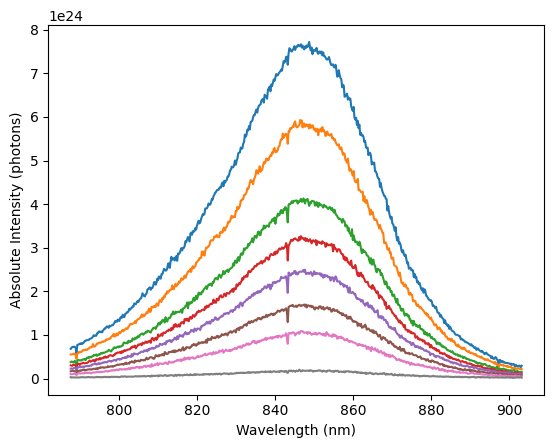

In [244]:
def open_file(filepath):
    with open(filepath, 'r+') as f:
        raw = f.read()

    # get all headers
    headers = np.array(raw.split('\n'))[0]
    headers = headers.split('\t')[1:]  # remove generic 'wl' header
    headers = (np.array(headers, dtype=float))

    # get wavelengths and ints
    raw = np.array(raw.split('\n'))[1:]
    raw = np.array([i.split('\t') for i in raw if len(i) > 0], dtype=float)

    wavelength = raw[:, 0]  # pop the wavelengths
    pl = raw[:, 1:]  # pop the intensities headers
    
    # baseline
    pl = pl - np.min(pl, axis=0)

    return headers, wavelength, pl

def processing(pls, wavelength, start, end, plot=True):

    n_wls = []
    n_pls = []

    for pl in pls.T:
        
        n_pl = pl[start:end]
        n_wl = wavelength[start:end]
       
        n_pl *= 3 # integration time in sec
        n_pl *= 5e11*(1240/n_wl) # counts to photons
        n_pl /= (40 * 40 * 1e-12)  # area in m^2

        # detector QE for 650 nm to 1050 nm
        detector_QE = 3.611624475091300E-13*(n_wl**6) - 1.917725566132970E-09*(n_wl**5) + 4.221574705418870E-06*(n_wl**4) \
            - 4.927570402158930E-03*(n_wl**3) + 3.213591581944010E+00*(n_wl**2) - 1.109299740317640E+03*n_wl + 1.582787629983810E+05
        detector_QE /= 100
        n_pl /= detector_QE

        n_pls.append(n_pl)
        n_wls.append(n_wl)

        if plot:
            plt.plot(n_wl, n_pl)
            plt.ylabel('Absolute Intensity (photons)')
            plt.xlabel(r'Wavelength (nm)')

    return n_pls, n_wls

headers, wavelength, pl = open_file('2024_Aug_10_GaAs_Wafer_v2_NoCover.txt')
pls, wls = processing(pl, wavelength, 650, 1200, plot=True)

In [ ]:
@cuda.jit(device=True)
def T_D(ex, eg, eu, th): 
    return (1/(2 * eu)) * math.exp(-((abs((ex-eg)/eu))**th))

@cuda.jit(device=True)
def G_s(ep, eg, eu, th, ex):
    return T_D(ep, 0, eu, th) * math.sqrt((ex - eg) - ep)

@cuda.jit(device=True)
def G(a, b, n, eg, eu, th, ex):

    h = (b - a) / n

    integral = 0.5 * G_s(a, eg, eu, th, ex) + 0.5 * G_s(b, eg, eu, th, ex)
    for i in range(1, n):
        integral += G_s(a + i * h, eg, eu, th, ex)
    integral *= h
    
    return integral

@cuda.jit(device=True)
def alpha_s(eg, eu, th, ex, alpha_0):
    return G(-eg, ex - eg, 1000, eg, eu, th, ex) * alpha_0

@cuda.jit(device=True)
def ed(ex, ef, eh, kt):
    return (1 - 1/(math.exp((ex - eh)/kt) + 1)) - (1/(math.exp((ex - ef)/kt) + 1))

@cuda.jit(device=True)
def a_s(eg, eu, th, ex, alpha_0, ef, eh, kt):
    return 1 - math.exp(-alpha_s(eg, eu, th, ex, alpha_0) * ed(ex, ef, eh, kt))

@cuda.jit(device=True)
def I_sn(eg, ex, eu, alpha_0, kt, ef, eh, th):
    return (2 * math.pi / ((h**3) * (c**2))) * ((ex**2)/(math.exp((ex - (ef - eh))/(kt)) - 1)) * a_s(eg, eu, th, ex, alpha_0, ef, eh, kt)

@cuda.jit
def pl_kernel(hvs, pred, eg, eu, alpha_0, kt, ef, eh, th):
    col, row = cuda.grid(2)

    if row < hvs.shape[0] and col < hvs.shape[1]:

        pred[row, col] = I_sn(eg[0], hvs[row, col], eu[0], alpha_0[row], kt[0], ef[row], eh[row], th[0])

In [ ]:
# IMPORTANT RUN THIS CELL ONLY IF YOU WANT TO USE THE ASSUMPTIONS ON ∆n, ND... 
# DO NOT RUN THIS CELL IF YOU WANT TO DO FULL EQUATION FITTING
# if you run this cell also adjust the fit functions accodingly

@cuda.jit(device=True)
def ed(ex, dmu, kt):
    return 1 - (2 / (math.exp((ex - dmu)/(2 * kt)) + 1))  # high ∆n
    return (math.exp((ex - ef)/kt) - math.exp(-ex/kt)) / (math.exp((ex - ef)/kt) + math.exp(-ex/kt) + math.exp((- ef)/kt) + 1) # high ND
    return 0.5 - (1 / (math.exp((ex - ef)/(1 * kt)) + 1))

@cuda.jit(device=True)
def a_s(eg, eu, th, ex, alpha_0, dmu, kt):
    return 1 - math.exp(-alpha_s(eg, eu, th, ex, alpha_0) * ed(ex, dmu, kt))

@cuda.jit(device=True)
def I_sn(eg, ex, eu, alpha_0, kt, dmu, th):
    return (2 * math.pi / ((h**3) * (c**2))) * ((ex**2)/(math.exp((ex - dmu)/(kt)) - 1)) * a_s(eg, eu, th, ex, alpha_0, dmu, kt)

@cuda.jit
def pl_kernel(hvs, pred, eg, eu, alpha_0, kt, dmu, th):
    col, row = cuda.grid(2)

    if row < hvs.shape[0] and col < hvs.shape[1]:

        pred[row, col] = I_sn(eg[0], hvs[row, col], eu[0], alpha_0[row], kt[0], dmu[row], th[0])

In [208]:
def nii(T, Eg=1.42, N_D=1e23, dn=1e20, m_e=0.063, m_h=0.51, doped=True):
    
    k = 1.380649e-23
    h = 6.626e-34
    m0 = 9.109e-31

    m_e_star = m_e * m0
    m_h_star = m_h * m0

    Nc = 2 * ((2 * np.pi * m_e_star * k * T / (h**2))**(3/2))
    Nv = 2 * ((2 * np.pi * m_h_star * k * T / (h**2))**(3/2))

    ni = np.sqrt(Nc * Nv * np.exp(-Eg/(KB*T)))
    
    if doped:
        n0 = N_D
        p0 = (ni**2/N_D)
    else:
        # m_e* x m_h* = ((n0*p0 * np.exp(Eg/(KB*T)) / ((2 * ((2 * np.pi * k * T / (h**2))**(3/2)))**2))**(2/3))/(m0**2)
        n0 = ni
        p0 = ni

    Efe = Eg - KB * T * np.log(Nc/(n0 + dn))
    Efh = KB * T * np.log(Nv/(p0 + dn))
    
    return Efe, Efh

nii(300, Eg=1.46, dn=1e23, m_e=0.5, m_h=1.5, doped=False)

(1.344041759697963, 0.15856021263595127)

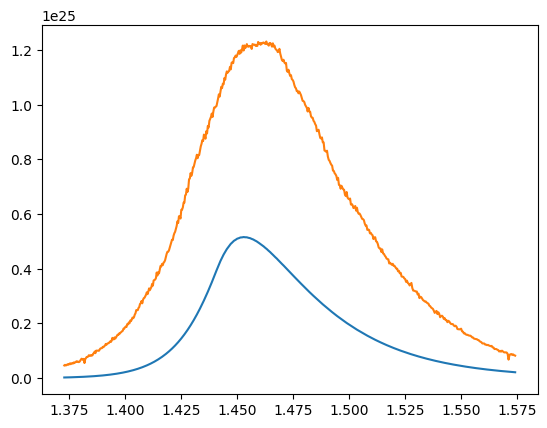

In [ ]:
# initilize gpu
device = torch.device("cuda") 

sample_id = 0

# get single intensity
intensity = torch.from_numpy(np.array([pls[sample_id]]))
intensity = intensity.to(device)

# get energy
hv = torch.from_numpy(1240/np.array([wls[sample_id]]))
hv = hv.to(device)
hv = cuda.as_cuda_array(hv)

# placeholder for result
pred = cuda.device_array_like(hv)

# paramaters
r_alpha_0 = cuda.as_cuda_array(torch.tensor([50], device=device))
r_Eg = cuda.as_cuda_array(torch.tensor([1.422], device=device))
r_Eu = cuda.as_cuda_array(torch.tensor([0.0091], device=device))
r_KT = cuda.as_cuda_array(torch.tensor([KB * 330], device=device))
r_Th = cuda.as_cuda_array(torch.tensor([1.0], device=device))

r_Ef = cuda.as_cuda_array(torch.tensor([nii(330, Eg=1.422, dn=1e23, m_e=0.063, m_h=0.51, doped=True)[0]], device=device))
r_Eh = cuda.as_cuda_array(torch.tensor([nii(330, Eg=1.422, dn=1e23, m_e=0.063, m_h=0.51, doped=True)[1]], device=device))

threads_per_block = (16, 16)
blocks_per_grid = 2048

pl_kernel[blocks_per_grid, threads_per_block](hv, pred, r_Eg, r_Eu, r_alpha_0, r_KT, r_Ef, r_Eh, r_Th)

pred = torch.as_tensor(pred, device='cuda').to('cpu').numpy() 

plt.plot(1240/np.array(wls[sample_id]), pred[sample_id])#/np.max(pred[sample_id]))
plt.plot(1240/np.array(wls[sample_id]), pls[sample_id])#/np.max(pls[sample_id]))

In [221]:
# function for single emission doped GaAs
def se_generic(x, eu, eg, dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8, dn9, s, kt, scale):

    # initilize gpu
    device = torch.device("cuda") 

    # GaAs doping level
    doping = 1e23

    # determine the QFLSs from ∆n using ni, me*, and mh* NOTE: different for doped sample
    dns = np.array([dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8, dn9])
    e_qfls, h_qfls = nii(kt, Eg=eg, N_D=doping, dn=dns)

    # get wl and prep for gpu
    hvs = torch.from_numpy(1240/np.array(x))
    hvs = hvs.to(device)
    hvs = cuda.as_cuda_array(hvs)
    
    # initilize
    pred = cuda.device_array_like(hvs)

    # initilize for gpu
    eu, eg, kt = [cuda.as_cuda_array(torch.tensor([i], device=device)) for i in [eu, eg, KB * kt]]

    # combine the QFLSs
    e_qfls = cuda.as_cuda_array(torch.tensor(e_qfls, device=device))
    h_qfls = cuda.as_cuda_array(torch.tensor(h_qfls, device=device))
    
    # assuming diffusion length stays the same for different injections
    s = cuda.as_cuda_array(torch.tensor([s, s, s, s, s, s, s, s, s], device=device))

    # preform fitting
    pl_kernel[blocks_per_grid, threads_per_block](hvs, pred, eg, eu, s, kt, e_qfls, h_qfls, 
                                                  cuda.as_cuda_array(torch.tensor([1], device=device)) # theta = 1
                                                  )
    spectra_combined = torch.as_tensor(pred, device='cuda')
    return scale*spectra_combined.to('cpu').numpy().flatten()

# get the spectra
ints = np.array(pls[:9])
hvs = np.array(wls[:9])

initial_guesses = {'eu':0.0099, 'eg':1.422, # guess urbach energy and band gap
                    'dn1':1e23, 'dn2':1e23, 'dn3':1e23, 'dn4':2e23, 'dn5':2e23, 'dn6':3e23, 'dn7':3e23, 'dn8':4e23, 'dn9':4e23, # guess ∆n
                    's':50, # guess diffusion length * absorption coefficient
                    'kt':325, # guess temp
                    'scale':1, # guess scaling
                    }

# preform curve fit on gpu
GaAs_fit, _ = curve_fit(se_generic, hvs, ints.flatten(), p0=list(initial_guesses.values()), maxfev=80_000)
eu, eg, dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8, dn9, s, kt, scale = GaAs_fit

# calculate r2 score
predicted_intensities = se_generic(hvs, *GaAs_fit)
r2 = r2_score(ints.flatten(), predicted_intensities)

print(f"R^2 = {r2}")
print([f"{list(initial_guesses.keys())[index]} = {p}" for index, p in enumerate(GaAs_fit)])

/scratch/f0061bz/ipykernel_3161064/787221721.py:23: RuntimeWarning: invalid value encountered in log
  Efe = Eg - KB * T * np.log(Nc/(n0 + dn))
/scratch/f0061bz/ipykernel_3161064/787221721.py:24: RuntimeWarning: invalid value encountered in log
  Efh = KB * T * np.log(Nv/(p0 + dn))


R^2 = 0.9996808282115806
['eu = 0.009504396271610538', 'eg = 1.4275200561574466', 'dn1 = 2.020199375674081e+21', 'dn2 = 4.3365950682153757e+21', 'dn3 = 6.579006677114597e+21', 'dn4 = 8.966483429680886e+21', 'dn5 = 1.1085695281005513e+22', 'dn6 = 1.3106876027052224e+22', 'dn7 = 1.5033146646479606e+22', 'dn8 = 1.7147192953624662e+22', 'dn9 = 1.926268415759993e+22', 's = 77.08500041528403', 'kt = 316.9675408456812', 'scale = 65.48705806340439']


In [ ]:
# combine fitted ∆ns
dns = np.array([dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8])

# calculate e and h QFLSs
e_qfls, h_qfls = nii(kt, Eg=eg, N_D=1e23, dn=dns)

# calculate ∆µ
dmu = e_qfls-h_qfls

dmu

array([1.26957393, 1.29101199, 1.30297343, 1.31217068, 1.31827121,
       1.32323347, 1.3273872 , 1.33136768, 1.33498988])

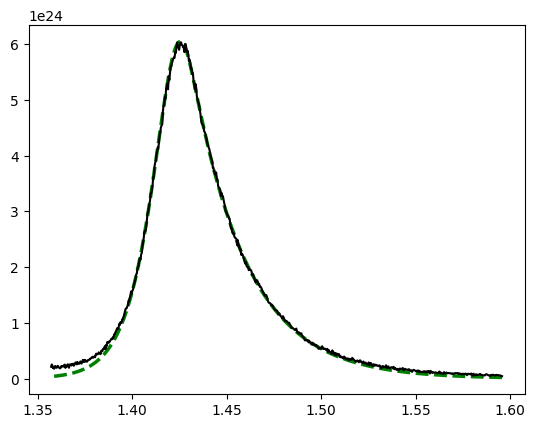

In [ ]:
sample_id = 0
plt.plot(1240/hvs[sample_id], predicted_intensities.reshape(ints.shape)[sample_id], linewidth=2.5, linestyle='--', color='green', label='Double Emission')
plt.plot(1240/hvs[sample_id], ints[sample_id], color='black', label='Measured')


In [250]:
# generic double emission
def de_generic(x, 
               eu_A, eg_A, eu_B, eg_B, # band gaps and urbach energies
               me_A, me_B, mh, # effective masses
               dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8, # ∆n
               s, # diffusion length * absorption coefficient
               kt, # temp
               scaling,
               isolate=0 # option for displaying 
               ):

    # initilize gpu
    device = torch.device("cuda")

    # get wl and prep for gpu
    hvs = torch.from_numpy(1240/np.array(x))
    hvs = hvs.to(device)
    hvs = cuda.as_cuda_array(hvs)

    # determine the QFLSs from ∆n using ni, me*, and mh*
    dns = np.array([dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8])
    e_qfls_A, h_qfls_A = nii(kt, Eg=eg_A, dn=dns, m_e=me_A, m_h=mh, doped=False)
    e_qfls_B, h_qfls_B = nii(kt, Eg=eg_B, dn=dns, m_e=me_B, m_h=mh, doped=False)

    # initilize place holders
    pred_A = cuda.device_array_like(hvs)
    pred_B = cuda.device_array_like(hvs)

    # initilize for gpu
    eu_A, eg_A, eu_B, eg_B, kt = [cuda.as_cuda_array(torch.tensor([i], device=device)) for i in [eu_A, eg_A, eu_B, eg_B, KB * kt]]

    # assume same s
    s = cuda.as_cuda_array(torch.tensor([s, s, s, s, s, s, s, s], device=device))
    
    # fit first emission
    pl_kernel[blocks_per_grid, threads_per_block](hvs, pred_A, eg_A, eu_A, s, kt, e_qfls_A, h_qfls_A, 
                                                  cuda.as_cuda_array(torch.tensor([1], device=device)) # theta = 1
                                                  )
    spectra_combined = torch.as_tensor(pred_A, device='cuda')

    # NOT FOR FITTING option to only display first emission for graph
    if isolate == 1:
        return scaling * torch.as_tensor(pred_A, device='cuda').to('cpu').numpy().flatten()

    
    # fit second emission
    pl_kernel[blocks_per_grid, threads_per_block](hvs, pred_B, eg_B, eu_B, s, kt, e_qfls_B, h_qfls_B, 
                                                  cuda.as_cuda_array(torch.tensor([1], device=device)) # theta = 1
                                                  )
    
    # combine emissions
    spectra_combined += torch.as_tensor(pred_B, device='cuda')
    
    # NOT FOR FITTING option to only display second emission for graph
    if isolate == 2:
        return  scaling * torch.as_tensor(pred_B, device='cuda').to('cpu').numpy().flatten()
   
    return  scaling * spectra_combined.to('cpu').numpy().flatten()


# get wavelengths and PL
ints = np.array(pls[-8:])
hvs = np.array(wls[-8:])

initial_guesses = {'eu_A':0.012, 'eg_A':1.44, 'eu_B':0.012, 'eg_B':1.46,
                   'me_A':0.1, 'me_B':0.1, 'mh':0.6,
                   'dn1':4e23, 'dn2':4e23, 'dn3':4e23, 'dn4':4e23, 'dn5':4e23, 'dn6':4e23, 'dn7':4e23, 'dn8':4e23,
                   's':10,
                   'kt':380,
                   'scaling':1
                   }

# preform curve fit on gpu
DE_fit, _ = curve_fit(de_generic, hvs, ints.flatten(),p0=list(initial_guesses.values()), maxfev=80_000)
eu_A, eg_A, eu_B, eg_B, me_A, me_B, mh, dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8, s, kt,_ = DE_fit

# calculate r2 score
predicted_intensities = de_generic(hvs, *DE_fit)
r2 = r2_score(ints.flatten(), predicted_intensities)

print(f"R^2 = {r2}")
[f"{list(initial_guesses.keys())[index]} = {p}" for index, p in enumerate(DE_fit)]

/dartfs-hpc/rc/home/z/f0061bz/.local/lib/python3.11/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/scratch/f0061bz/ipykernel_3161064/787221721.py:10: RuntimeWarning: invalid value encountered in scalar power
  Nc = 2 * ((2 * np.pi * m_e_star * k * T / (h**2))**(3/2))
/scratch/f0061bz/ipykernel_3161064/787221721.py:11: RuntimeWarning: invalid value encountered in scalar power
  Nv = 2 * ((2 * np.pi * m_h_star * k * T / (h**2))**(3/2))


R^2 = 0.9993668704181133


['eu_A = 0.012843142511708223',
 'eg_A = 1.4269126404875154',
 'eu_B = 0.014906049402269812',
 'eg_B = 1.449028226040523',
 'me_A = 0.31682307669425913',
 'me_B = 0.2632807422436917',
 'mh = 0.13307980920579168',
 'dn1 = 4.588904903064662e+23',
 'dn2 = 4.005793269496533e+23',
 'dn3 = 3.345310554334162e+23',
 'dn4 = 2.9613574406819613e+23',
 'dn5 = 2.5838303451584117e+23',
 'dn6 = 2.135498931990548e+23',
 'dn7 = 1.6889705814525188e+23',
 'dn8 = 7.031725046817984e+22',
 's = 0.6753835666052926',
 'kt = 373.1425687955475',
 'scaling = 1.8933500399147034']

In [251]:
# combine fitted ∆ns
dns = np.array([dn1, dn2, dn3, dn4, dn5, dn6, dn7, dn8])

# calculate e and h QFLSs
e_qfls, h_qfls = nii(kt, Eg=eg_A, dn=dns, doped=False, m_e=me_A, m_h=mh)

# calculate ∆µ
dmu = e_qfls-h_qfls

dmu

array([1.30124157, 1.29250187, 1.28091439, 1.27307426, 1.26430401,
       1.25204832, 1.23696244, 1.1806095 ])

In [252]:
# calculate e and h QFLSs
e_qfls, h_qfls = nii(kt, Eg=eg_B, dn=dns, doped=False, m_e=me_B, m_h=mh)

# calculate ∆µ
dmu = e_qfls-h_qfls

dmu

array([1.33228606, 1.32354636, 1.31195888, 1.30411875, 1.2953485 ,
       1.28309281, 1.26800693, 1.21165399])

/dartfs-hpc/rc/home/z/f0061bz/.local/lib/python3.11/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


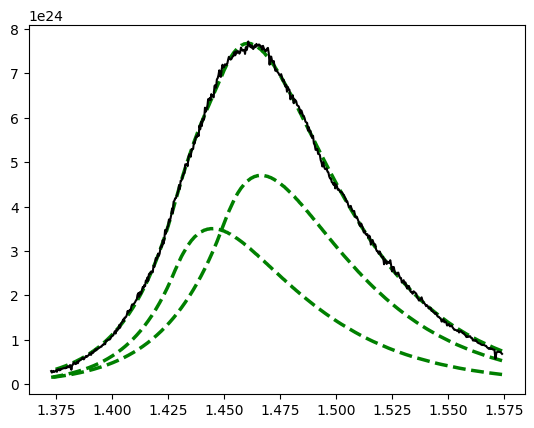

In [253]:
sample_id = 0
plt.plot(1240/hvs[sample_id], de_generic(hvs, *DE_fit).reshape(ints.shape)[sample_id], linewidth=2.5, linestyle='--', color='green', label='Double Emission')
plt.plot(1240/hvs[sample_id], de_generic(hvs, *DE_fit, isolate=1).reshape(ints.shape)[sample_id], linewidth=2.5, linestyle='--', color='green', label='Double Emission')
plt.plot(1240/hvs[sample_id], de_generic(hvs, *DE_fit, isolate=2).reshape(ints.shape)[sample_id], linewidth=2.5, linestyle='--', color='green', label='Double Emission')
plt.plot(1240/hvs[sample_id], ints[sample_id], color='black', label='Measured')
